In [1]:
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import SVI, JitTrace_ELBO
from pyro.optim import Adam
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
import us
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy.optimize import root
from scipy.io import loadmat
pyro.enable_validation()

In [2]:
freyfaces = loadmat('../data/frey_faces/frey_rawface.mat')
freyfaces = np.reshape(np.transpose(freyfaces['ff']), (-1, 28, 20))

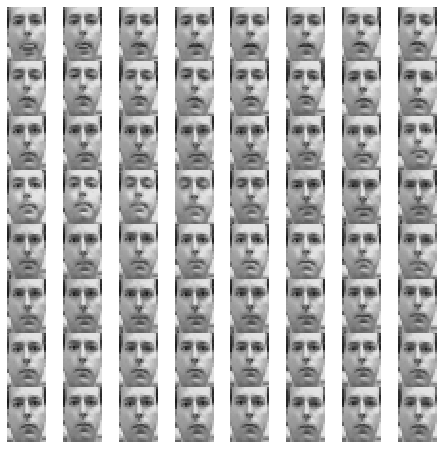

In [3]:
fig = plt.figure(figsize=(8, 8))
for i in range(64):
    sub = fig.add_subplot(8, 8, i + 1)
    sub.set_axis_off()
    sub.imshow(freyfaces[i], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
fig.subplots_adjust(wspace=0, hspace=0)

In [4]:
freyfaces_size = freyfaces.shape[0]
freyfaces_dataset = torch.utils.data.TensorDataset(torch.tensor(freyfaces, dtype=torch.float) / 255.)
test_size = int(0.1 * freyfaces_size)
freyfaces_train, freyfaces_test = torch.utils.data.random_split(freyfaces_dataset, [freyfaces_size - test_size, test_size])

In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(freyfaces_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(freyfaces_test, batch_size=batch_size)

In [6]:
print(freyfaces_size)
img_dims = 28*20
print(img_dims)

1965
560


In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(img_dims, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, img_dims)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [8]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, img_dims)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x (28*20)
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [9]:
# Train VAE based on Pyro's VAE tutorial 
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # 200 hidden units as described in the paper
    def __init__(self, z_dim=50, hidden_dim=200, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img, validate_args=False).to_event(1), obs=x.reshape(-1, img_dims))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [10]:
### Hyperparameters:
LEARNING_RATE = 5e-3
# THROWS ERROR IF LEARNING RATE IS SET TOO HIGH
USE_CUDA = False
NUM_EPOCHS = 100
TEST_FREQ = 5

vae = VAE(use_cuda=USE_CUDA)
optimizer = Adam({"lr": LEARNING_RATE})

svi = SVI(vae.model, vae.guide, optimizer, loss=JitTrace_ELBO())

def train(svi, train_loader, use_cuda=USE_CUDA):
    epoch_loss = 0
    for tensor_list in train_loader:
        for x in tensor_list:
            if use_cuda:
                x = x.cuda()
            epoch_loss += svi.step(x)
    
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=USE_CUDA):
    test_loss = 0
    for tensor_list in test_loader:
        for x in tensor_list:
            if use_cuda:
                x = x.cuda()
            test_loss += svi.evaluate_loss(x)
            
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_train = test_loss / normalizer_test
    return total_epoch_loss_train

In [11]:
pyro.clear_param_store()

train_elbo = []
test_elbo = []
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch {}] average train loss: {}".format(epoch, total_epoch_loss_train))
    
    if epoch % TEST_FREQ == 0:
        total_epoch_loss_test = evaluate(svi, train_loader, USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch {}] average test loss: {}".format(epoch, total_epoch_loss_test))

[epoch 0] average train loss: 371.13682474208593
[epoch 0] average test loss: 356.7955879138108
[epoch 1] average train loss: 354.96255387931035
[epoch 2] average train loss: 353.05113897329
[epoch 3] average train loss: 352.45839810627473
[epoch 4] average train loss: 352.2242527557942
[epoch 5] average train loss: 352.1458186122103
[epoch 5] average test loss: 352.1810982436228
[epoch 6] average train loss: 352.1094434532222
[epoch 7] average train loss: 352.0822454423403
[epoch 8] average train loss: 352.07786664429057
[epoch 9] average train loss: 352.0818347230074
[epoch 10] average train loss: 352.0894926512154
[epoch 10] average test loss: 352.1915622018973
[epoch 11] average train loss: 352.0775707497174
[epoch 12] average train loss: 352.08484887295083
[epoch 13] average train loss: 352.0810397823629
[epoch 14] average train loss: 352.1026400862069
[epoch 15] average train loss: 352.0941165559638
[epoch 15] average test loss: 352.19980667485163
[epoch 16] average train loss: 3

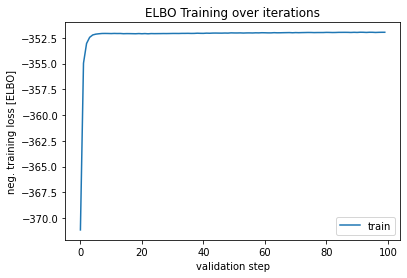

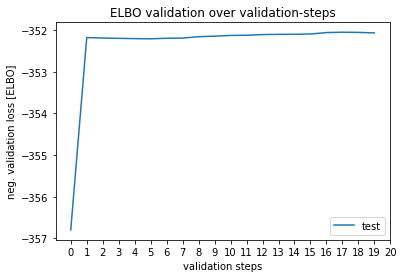

In [12]:
# Show ELBO plot
plt.plot(train_elbo, label="train")
plt.legend()
plt.title("ELBO Training over iterations")
plt.ylabel("neg. training loss [ELBO]")
plt.xlabel("validation step")
plt.savefig("./training_ELBO.png")
plt.show()

plt.plot(test_elbo, label="test")
plt.legend()
plt.title("ELBO validation over validation-steps")
plt.ylabel("neg. validation loss [ELBO]")
plt.xlabel("validation steps")
plt.xticks(np.arange(0, int(NUM_EPOCHS/TEST_FREQ)+.1, step=1))
plt.savefig("./validation_ELBO.png")
plt.show()

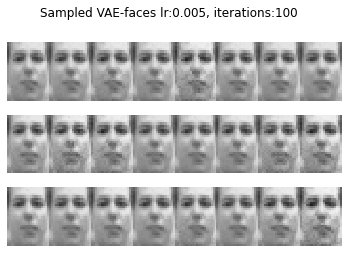

In [13]:
# sample faces from encoder
x = torch.zeros([1, img_dims])    
  
fig, axs = plt.subplots(nrows=3, ncols=8)
for ax in axs.ravel():
    sampled_img = vae.reconstruct_img(x)
    # reshape data into 28x20 dimensions
    img = sampled_img[0].view(28,20).cpu().data.numpy()
    ax.set_axis_off()
    # adjust min and max values in [0,1] interval
    ax.imshow(img, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Sampled VAE-faces lr:{}, iterations:{}".format(LEARNING_RATE, NUM_EPOCHS))
plt.savefig("/home/rimichael/Uni/KU_BioInf/ProMo/deep-probprog-course/week2/sampled_faces{}{}.png".format(LEARNING_RATE, NUM_EPOCHS))